# Capital One Data Science Challenge: An Analysis of Card Transactions

### Initials: Y.T. 
### Version of submission : v20.01
### Candidate ID : C1552034

In [1]:
# import packages
import sys
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

import warnings
warnings.filterwarnings("ignore")
import numpy as np

from zipfile import ZipFile 
from tqdm import tqdm
import json

import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import ConnectionPatch
import matplotlib.patches as mpatches

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score, make_scorer,f1_score,recall_score

## Question 1: Load Data

### 1.1 Programmatically download and load into your favorite analytical tool the transactions data.

In [2]:
!git clone https://github.com/CapitalOneRecruiting/DS.git 

Cloning into 'DS'...


In [3]:
# specify the file name
file_name = "DS/transactions.zip"
  
# extracting all the files 
with ZipFile(file_name, 'r') as zip: 
    zip.extractall() 

In [4]:
# open the file
trx = open('transactions.txt', 'r')

#convert into a dataframe
totals = []
d = trx.readlines()

for i in tqdm(range(len(d))):
    dic = json.loads(d[i])
    totals.append(dic)

df = pd.DataFrame(totals)
df

100%|██████████| 786363/786363 [00:11<00:00, 69177.72it/s]


,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.00,2016-08-13T14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,,0.00,,,,False,,,False,False
1,737265056,737265056,5000.0,5000.00,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.00,,,,True,,,False,False
2,737265056,737265056,5000.0,5000.00,2016-11-08T09:18:39,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.00,,,,False,,,False,False
3,737265056,737265056,5000.0,5000.00,2016-12-10T02:14:50,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.00,,,,False,,,False,False
4,830329091,830329091,5000.0,5000.00,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,,0.00,,,,True,,,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786358,732852505,732852505,50000.0,48904.96,2016-12-22T18:44:12,119.92,Lyft,US,US,90,01,rideshare,12/2022,2012-08-23,2012-08-23,936,936,3783,PURCHASE,,1095.04,,,,False,,,False,False
786359,732852505,732852505,50000.0,48785.04,2016-12-25T16:20:34,18.89,hulu.com,US,US,09,01,online_subscriptions,08/2023,2012-08-23,2012-08-23,939,939,3388,PURCHASE,,1214.96,,,,False,,,False,False
786360,732852505,732852505,50000.0,48766.15,2016-12-27T15:46:24,49.43,Lyft,US,US,02,01,rideshare,08/2025,2012-08-23,2012-08-23,936,936,3783,PURCHASE,,1233.85,,,,False,,,False,False
786361,732852505,732852505,50000.0,48716.72,2016-12-29T00:30:55,49.89,walmart.com,US,US,09,99,online_retail,07/2022,2012-08-23,2012-08-23,939,939,3388,PURCHASE,,1283.28,,,,False,,,False,False


### 1.2 Please describe the structure of the data. Number of records and fields in each record?

In [5]:
print("This dataset has {} rows and {} columns.\n".format(str(len(df)), len(df.columns)))

print("The dataset has {} unique account ids.".format(df.accountNumber.nunique()))

print("It captures transaction history for {} accounts between the period {} and {}. \n".
format(df.accountNumber.nunique(),min(df.transactionDateTime), max(df.transactionDateTime) ))

print("The transaction involves {} merchants in the following categories: \n{}. \n".
format(df.merchantName.nunique(), df.merchantCategoryCode.unique()))

print("The merchants locate in the following countries: \n {} \n".format(list(filter(None, df.merchantCountryCode.unique().tolist()))))

print("The target variable is 'is_Fraud', we have {} to indicate whether it is a fraud transaction in this column \n".
      format(df.isFraud.unique()))

This dataset has 786363 rows and 29 columns.

The dataset has 5000 unique account ids.
It captures transaction history for 5000 accounts between the period 2016-01-01T00:01:02 and 2016-12-30T23:59:45. 

The transaction involves 2490 merchants in the following categories: 
['rideshare' 'entertainment' 'mobileapps' 'fastfood' 'food_delivery'
 'auto' 'online_retail' 'gym' 'health' 'personal care' 'food' 'fuel'
 'online_subscriptions' 'online_gifts' 'hotels' 'airline' 'furniture'
 'subscriptions' 'cable/phone']. 

The merchants locate in the following countries: 
 ['US', 'CAN', 'PR', 'MEX'] 

The target variable is 'is_Fraud', we have [False  True] to indicate whether it is a fraud transaction in this column 



### 1.3 Please provide some additional basic summary statistics for each field. Be sure to include a count of null, minimum, maximum, and unique values where appropriate

In this section, we checked 
- count of null /percent of missing values for each column
- distribution(minimum and maximum) for each column
- unique values for each column
- different data types

In [6]:
# import functions from util1.py
from util1 import percent_missing_values, datatype_summary

#### Analysis of null/missing values

In [7]:
df.isnull().sum()

accountNumber               0
customerId                  0
creditLimit                 0
availableMoney              0
transactionDateTime         0
transactionAmount           0
merchantName                0
acqCountry                  0
merchantCountryCode         0
posEntryMode                0
posConditionCode            0
merchantCategoryCode        0
currentExpDate              0
accountOpenDate             0
dateOfLastAddressChange     0
cardCVV                     0
enteredCVV                  0
cardLast4Digits             0
transactionType             0
echoBuffer                  0
currentBalance              0
merchantCity                0
merchantState               0
merchantZip                 0
cardPresent                 0
posOnPremises               0
recurringAuthInd            0
expirationDateKeyInMatch    0
isFraud                     0
dtype: int64

In [8]:
# replace '' to null for better detect the missing values
df = df.replace('', np.NaN)
percent_missing_values(df)

,percent_missing
recurringAuthInd,100.000000
posOnPremises,100.000000
merchantZip,100.000000
merchantState,100.000000
merchantCity,100.000000
echoBuffer,100.000000
acqCountry,0.580139
posEntryMode,0.515538
merchantCountryCode,0.092069
transactionType,0.088763


#### Descriptive Analysis

In [9]:
df.describe()

,creditLimit,availableMoney,transactionAmount,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,posOnPremises,recurringAuthInd
count,786363.000000,786363.000000,786363.000000,0.0,786363.000000,0.0,0.0,0.0,0.0,0.0
mean,10759.464459,6250.725369,136.985791,NaN,4508.739089,NaN,NaN,NaN,NaN,NaN
std,11636.174890,8880.783989,147.725569,NaN,6457.442068,NaN,NaN,NaN,NaN,NaN
min,250.000000,-1005.630000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
25%,5000.000000,1077.420000,33.650000,NaN,689.910000,NaN,NaN,NaN,NaN,NaN
50%,7500.000000,3184.860000,87.900000,NaN,2451.760000,NaN,NaN,NaN,NaN,NaN
75%,15000.000000,7500.000000,191.480000,NaN,5291.095000,NaN,NaN,NaN,NaN,NaN
max,50000.000000,50000.000000,2011.540000,NaN,47498.810000,NaN,NaN,NaN,NaN,NaN


By looking at the distribution (minimum, 25%, 50%, 75%, maximun) and standard deviation of these 4 numerical columns, it is noticed that
- all of our numerical features have distributions __skew to the right__, which means most of the values are relatively small amounts. 
- they all have large standard deviation values, which tells that the average amount of variability for each column is large.

#### Analysis on unique values

In [10]:
unique_value_cnt = df.nunique()
unique_value_cnt_df = pd.DataFrame({'unique_value_cnt': unique_value_cnt})
unique_value_cnt_df = unique_value_cnt_df.sort_values('unique_value_cnt',ascending = False)
unique_value_cnt_df

,unique_value_cnt
transactionDateTime,776637
availableMoney,521916
currentBalance,487318
transactionAmount,66038
cardLast4Digits,5246
accountNumber,5000
customerId,5000
merchantName,2490
dateOfLastAddressChange,2184
accountOpenDate,1820


__It is noticed that:__
- We have 5000 distinct accountNumber with 5246 cardLast4Digits, which indicates some customers hold multiple cards with different plastic number
- merchantZip, merchantState,posOnPremises，recurringAuthInd，merchantCity and echoBuffer have the same value in all rows, which didn't provide us much useful information. 

#### Analysis on data types

In [11]:
datatype_summary(df)               

The columns with all NULL values are:  ['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd']
The columns with 80% NULL values are:  []
The numerical columns are:  ['creditLimit', 'availableMoney', 'transactionAmount', 'currentBalance']
The object columns are:  ['accountNumber', 'customerId', 'transactionDateTime', 'merchantName', 'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode', 'merchantCategoryCode', 'currentExpDate', 'accountOpenDate', 'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits', 'transactionType']
The boolean columns are:  ['cardPresent', 'expirationDateKeyInMatch', 'isFraud']


# Question 2 : Plot

### 2.1 Plot a histogram of the processed amounts of each transaction, the transactionAmount column.

In [12]:
# import reusuable functions from the util1.py
from util1 import histogram, bar_plot, pie_chart, distribution_plot

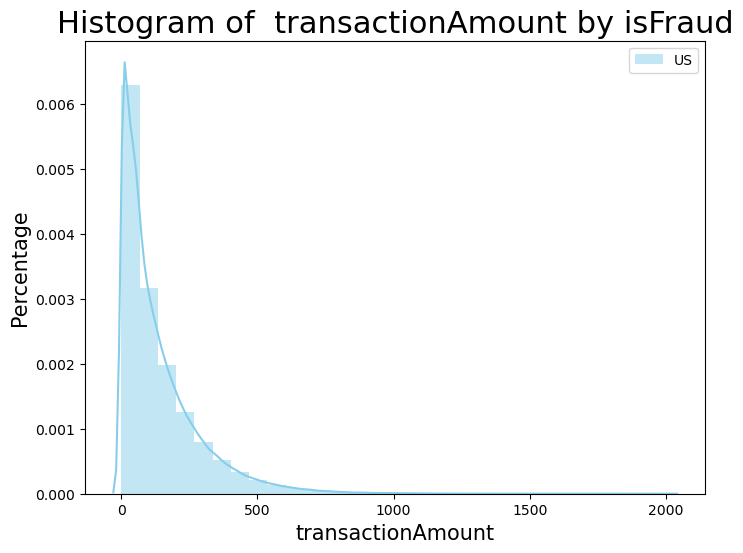

In [13]:
histogram(col='transactionAmount', df1=df, df2=None,label1 = 'US',label2='', size = (8,6))

### 2.2 Report any structure you find and any hypotheses you have about that structure

It is noted from the plot above (Histogram of Transaction amounts) that 
- the histogram for transactionAmount indicates the data is right-skewed. 
- Most of the transactionAmount concentrated between 0 to 500 dollars

But we can look at the transaction amounts from different perspectives to see if there is any interesting findings. Three analysis are run to validate the following hypothesis:
- It is hypothesized that the transaction amount distribution is different between US and not US countries
- It is hypothesized that the transaction amount distribution is different in whether the card is presented in the transaction
- It is hypothesized that the transaction amount distribution is different in whether the transaction is fraud


#### 2.2.1 Dive into merchantCountryCode

##### Let's see if the distribution is consistent when merchants are in US and non-US 

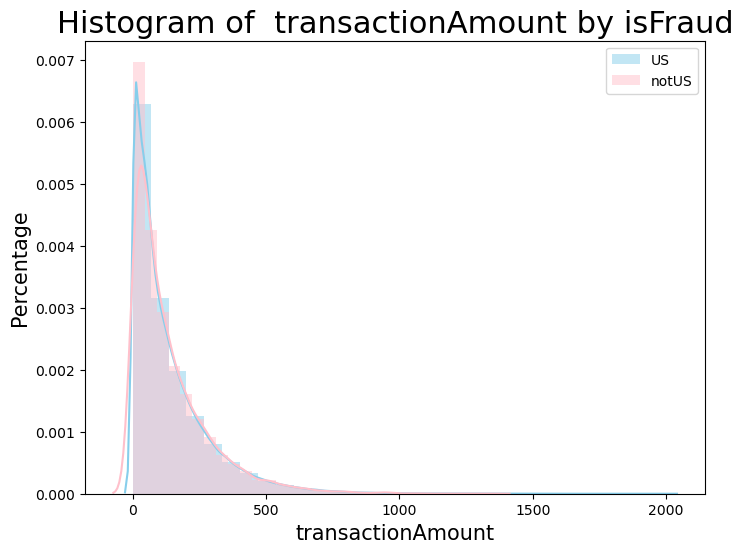

In [14]:
US = df.loc[df.merchantCountryCode=='US']
notUS = df.loc[df.merchantCountryCode!='US']

histogram(col='transactionAmount', df1=US, df2=notUS,label1 = 'US',label2 ='notUS', size = (8,6))

#### 2.2.2 Dive into cardPresent
##### Let's see if the distribution is consistent in whether the card is presented at transaction

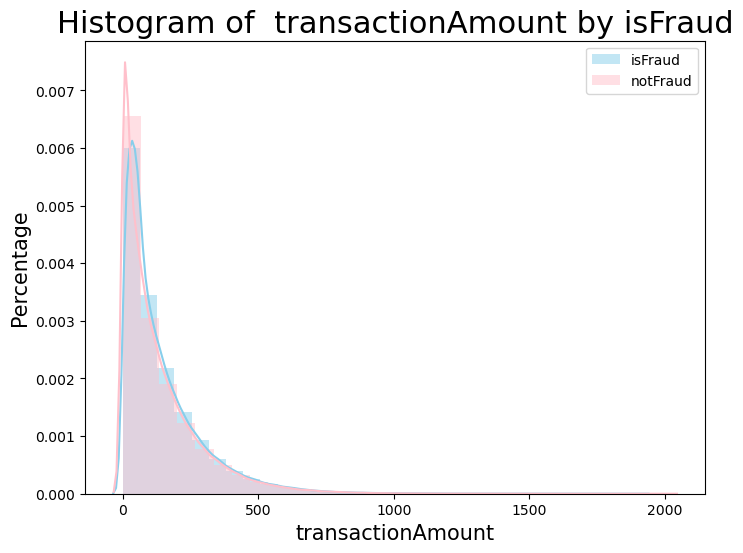

In [15]:
cardPresent_true = df.loc[df.cardPresent==True]
cardPresent_false = df.loc[df.cardPresent==False]
histogram(col='transactionAmount', df1=cardPresent_true, df2=cardPresent_false, 
          label1 = 'isFraud',label2 ='notFraud', size = (8,6))

#### 2.2.3 Dive into isFraud
##### Let's see if the distribution is consistent in whether the transaction is fraud

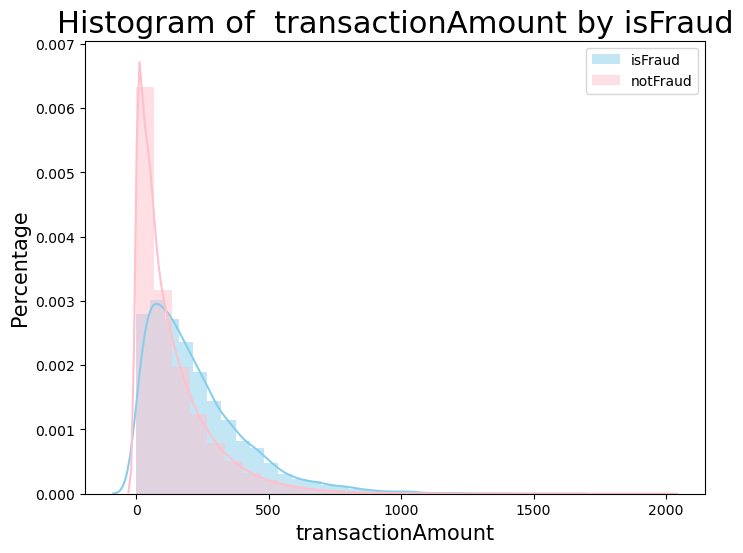

In [16]:
isFraud = df.loc[df.isFraud==True]
notFraud = df.loc[df.isFraud==False]

histogram(col='transactionAmount', df1=isFraud, df2=notFraud, 
          label1 = 'isFraud',label2 ='notFraud', size = (8,6))

__Summary:__
After conducting the 3 analysis from the presepective of merchant country, whether the card is presented and whether this is a fraud transaction, it is concluded that:
- the distribution are similar in US and non-US countries
- the distribution are similar in whether the card is presented when the transaction is conducted
- there is __big difference__ on distribution for whether this is a fraud transaction. The histogram tells that the __distribution of true transaction amounts are more skewed to the right__ comparing to fraud. It indicates that the true transaction amounts are more concentrated on smaller amounts, while fraud transaction amounts are generaly larger.

## Question 3: Data Wrangling - Duplicate Transactions

### 3.1 Can you programmatically identify reversed and multi-swipe transactions?


#### 3.1.1 Reversed transactions

In [17]:
df['transactionType'].value_counts()

PURCHASE                745193
REVERSAL                 20303
ADDRESS_VERIFICATION     20169
Name: transactionType, dtype: int64

By showing all the transaction type, it is noted that we have the type 'REVERSAL'. Therefore, the reversed transactions are: 

In [18]:
reversal = df.loc[df.transactionType == 'REVERSAL']

In [19]:
print('There are {} reversed transactions'.format(len(reversal)))

There are 20303 reversed transactions


#### 3.1.2  Multi-swipe transactions

Since there is no transaction type called 'multi-swipe' which enables us to identify the transactions, we need to self-define the multi-swipe transactions
- __Starting population__: transactionType not in ('REVERSAL', 'ADDRESS_VERIFICATION') as they have specific stated transaction type and usually do not have multi-swipe scenario
- __Filter__ by finding accounts with more than 1 transactions

In [20]:
start_pop = df.loc[(df.transactionType != 'REVERSAL') & (df.transactionType != 'ADDRESS_VERIFICATION')]
print('There are {} transactions for the starting population.'.format(len(start_pop)))

There are 745891 transactions for the starting population.


In [21]:
counts = df.groupby(['accountNumber', 'merchantName', 'transactionAmount', 'cardLast4Digits']).size().reset_index(name = 'counts')
multi_counts = counts.loc[counts.counts > 1, ]
print('There are {} transactions have almost another exactly the same transaction.'.format(len(multi_counts)))

There are 34864 transactions have almost another exactly the same transaction.


In [22]:
# Join with the starting population to get transactionDateTime
total_multi = pd.merge(start_pop, multi_counts, how='inner', on=['accountNumber','merchantName','transactionAmount', 'cardLast4Digits'])
print('By joining the starting population and the multi_counts, there are {} transactions to further investigate.'.format(len(total_multi)))

By joining the starting population and the multi_counts, there are 83018 transactions to further investigate.


In [23]:
# find the time between transactions
total_multi['transactionDateTime'] = pd.to_datetime(total_multi['transactionDateTime'])

total_multi['next_transactionDateTime'] = total_multi.groupby(['accountNumber', 'merchantName', 'transactionAmount', 'cardLast4Digits'])\
                                                    ['transactionDateTime'].shift(1)

total_multi['minutes_between_transaction'] = (total_multi['transactionDateTime'] - total_multi['next_transactionDateTime']).dt.total_seconds() / 60

# when the 2 transactions happen within 5 minutes
multi_swipe_pop = total_multi.loc[total_multi['minutes_between_transaction'] <= 5,]
multi_swipe_pop

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud,counts,next_transactionDateTime,minutes_between_transaction
30,984504651,984504651,50000.0,26680.99,2016-03-12 06:34:29,118.52,AMC #706324,US,US,02,01,entertainment,10/2024,2015-07-27,2015-07-27,640,640,8332,PURCHASE,NaN,23319.01,NaN,NaN,NaN,True,NaN,NaN,False,False,3,2016-03-12 06:34:13,0.266667
31,984504651,984504651,50000.0,26562.47,2016-03-12 06:36:41,118.52,AMC #706324,US,US,02,01,entertainment,10/2024,2015-07-27,2015-07-27,640,640,8332,PURCHASE,NaN,23437.53,NaN,NaN,NaN,True,NaN,NaN,False,False,3,2016-03-12 06:34:29,2.200000
35,984504651,984504651,50000.0,24316.12,2016-03-18 13:57:04,26.71,Planet Fitness #692929,US,US,02,01,health,10/2024,2015-07-27,2015-07-27,640,640,8332,PURCHASE,NaN,25683.88,NaN,NaN,NaN,True,NaN,NaN,False,False,2,2016-03-18 13:56:20,0.733333
38,984504651,984504651,50000.0,16503.49,2016-04-08 22:21:11,43.21,WSC #994275,US,US,02,08,health,02/2030,2015-07-27,2016-03-26,640,640,8332,PURCHASE,NaN,33496.51,NaN,NaN,NaN,False,NaN,NaN,False,False,2,2016-04-08 22:20:33,0.633333
50,984504651,984504651,50000.0,7302.32,2016-05-07 07:32:54,23.82,Golds Gym #846582,US,US,09,01,health,12/2030,2015-07-27,2016-05-05,640,640,8332,PURCHASE,NaN,42697.68,NaN,NaN,NaN,True,NaN,NaN,False,False,2,2016-05-07 07:30:02,2.866667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82898,207667444,207667444,7500.0,6893.70,2016-10-14 13:24:58,79.82,discount.com,US,US,02,01,online_retail,03/2025,2011-12-12,2016-08-16,235,235,9853,PURCHASE,NaN,606.30,NaN,NaN,NaN,False,NaN,NaN,False,False,2,2016-10-14 13:23:16,1.700000
82932,428856030,428856030,250.0,104.44,2016-10-30 20:59:18,314.07,Rodeway Inn #438868,US,US,02,01,hotels,02/2027,2009-08-17,2009-08-17,990,990,7660,PURCHASE,NaN,145.56,NaN,NaN,NaN,True,NaN,NaN,False,False,2,2016-10-30 20:58:43,0.583333
82953,205026043,205026043,5000.0,451.59,2016-06-07 22:29:11,391.94,Uber,US,US,09,08,rideshare,12/2029,2008-04-15,2008-04-15,198,198,3931,PURCHASE,NaN,4548.41,NaN,NaN,NaN,False,NaN,NaN,False,False,3,2016-06-07 22:27:35,1.600000
82954,205026043,205026043,5000.0,433.52,2016-06-07 22:30:57,391.94,Uber,US,US,09,08,rideshare,12/2029,2008-04-15,2008-04-15,198,198,3931,PURCHASE,NaN,4566.48,NaN,NaN,NaN,False,NaN,NaN,False,False,3,2016-06-07 22:29:11,1.766667


### 3.2 What total number of transactions and total dollar amount do you estimate for the reversed transactions?For the multi-swipe transactions? (please consider the first transaction to be "normal" and exclude it from the number of transaction and dollar amount counts)


#### 3.2.1 Total number of transactions and total dollar amount do you estimate for the reversed transactions

In [24]:
reversal.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
39,574788567,574788567,2500.0,2200.98,2016-05-24T01:38:03,215.13,Convenient Tire,US,US,09,01,auto,10/2021,2015-10-13,2015-10-13,206,206,8522,REVERSAL,NaN,299.02,NaN,NaN,NaN,True,NaN,NaN,False,False
73,574788567,574788567,2500.0,2432.72,2016-10-07T10:23:57,3.87,Eazy Repair,US,US,05,01,auto,10/2022,2015-10-13,2015-10-13,579,579,4219,REVERSAL,NaN,67.28,NaN,NaN,NaN,True,NaN,NaN,False,False
101,924729945,924729945,50000.0,49831.43,2016-10-19T14:01:45,168.57,discount.com,US,US,05,01,online_retail,11/2024,2014-07-25,2014-07-25,205,265,9459,REVERSAL,NaN,168.57,NaN,NaN,NaN,False,NaN,NaN,False,False
133,984504651,984504651,50000.0,46367.41,2016-01-16T09:53:15,450.74,Planet Fitness #849960,US,US,05,01,health,08/2028,2015-07-27,2015-07-27,640,640,8332,REVERSAL,NaN,3632.59,NaN,NaN,NaN,False,NaN,NaN,False,False
156,984504651,984504651,50000.0,41909.30,2016-01-25T20:39:15,81.73,AMC #724446,US,US,09,01,entertainment,12/2031,2015-07-27,2015-07-27,640,640,8332,REVERSAL,NaN,8090.70,NaN,NaN,NaN,True,NaN,NaN,False,False


In [25]:
print('There are {} reversed transactions'.format(len(reversal)))
print('The total dollar amount for reversed transaction is {}.'.format(round(sum(reversal.transactionAmount),2)))

There are 20303 reversed transactions
The total dollar amount for reversed transaction is 2821792.5.


#### 3.2.2 Total number of transactions and total dollar amount do you estimate for the  multi-swipe transactions

In [26]:
multi_swipe_pop.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud,counts,next_transactionDateTime,minutes_between_transaction
30,984504651,984504651,50000.0,26680.99,2016-03-12 06:34:29,118.52,AMC #706324,US,US,02,01,entertainment,10/2024,2015-07-27,2015-07-27,640,640,8332,PURCHASE,NaN,23319.01,NaN,NaN,NaN,True,NaN,NaN,False,False,3,2016-03-12 06:34:13,0.266667
31,984504651,984504651,50000.0,26562.47,2016-03-12 06:36:41,118.52,AMC #706324,US,US,02,01,entertainment,10/2024,2015-07-27,2015-07-27,640,640,8332,PURCHASE,NaN,23437.53,NaN,NaN,NaN,True,NaN,NaN,False,False,3,2016-03-12 06:34:29,2.200000
35,984504651,984504651,50000.0,24316.12,2016-03-18 13:57:04,26.71,Planet Fitness #692929,US,US,02,01,health,10/2024,2015-07-27,2015-07-27,640,640,8332,PURCHASE,NaN,25683.88,NaN,NaN,NaN,True,NaN,NaN,False,False,2,2016-03-18 13:56:20,0.733333
38,984504651,984504651,50000.0,16503.49,2016-04-08 22:21:11,43.21,WSC #994275,US,US,02,08,health,02/2030,2015-07-27,2016-03-26,640,640,8332,PURCHASE,NaN,33496.51,NaN,NaN,NaN,False,NaN,NaN,False,False,2,2016-04-08 22:20:33,0.633333
50,984504651,984504651,50000.0,7302.32,2016-05-07 07:32:54,23.82,Golds Gym #846582,US,US,09,01,health,12/2030,2015-07-27,2016-05-05,640,640,8332,PURCHASE,NaN,42697.68,NaN,NaN,NaN,True,NaN,NaN,False,False,2,2016-05-07 07:30:02,2.866667


In [27]:
print('There are {} reversed transactions'.format(len(multi_swipe_pop)))
print('The total dollar amount for reversed transaction is {}.'.format(round(sum(multi_swipe_pop.transactionAmount),2)))

There are 7457 reversed transactions
The total dollar amount for reversed transaction is 1104006.71.


### 3.3. Did you find anything interesting about either kind of transaction?

In this section, we will use __Multi swipe transaction__ as an example for analysis. I am interested in the following questions:
- Are the top transaction merchant category/name for multi-swipe transaction different from the total population?
- Does multi-swipe transaction contain more fraud transaction compare to the total transactions?
- Are the fraud transactions for multi-swipe transaction come from different merchant category/name than the total population?
- How are the transactionAmount distributed in multi-swipe transactions different from the total transaction?

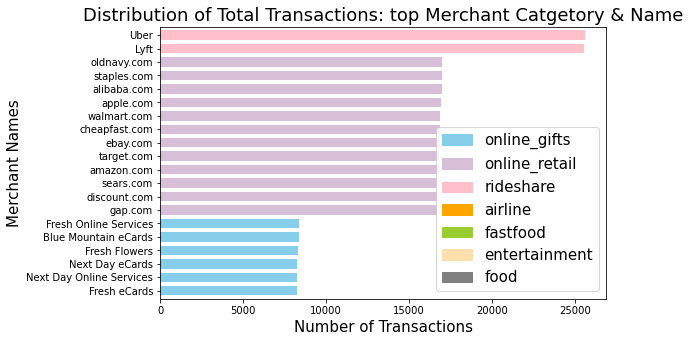

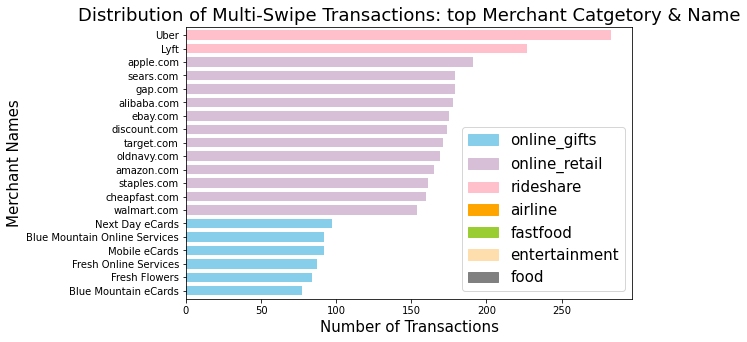

In [28]:
total_merchant_cat_name = df.groupby(['merchantName','merchantCategoryCode'] ).size().sort_values(ascending=False)
total_merchant_cat_name_top = pd.DataFrame(total_merchant_cat_name.head(20)).reset_index()
total_merchant_cat_name_top = total_merchant_cat_name_top.rename(columns={0: 'counts'})
total_merchant_cat_name_top = total_merchant_cat_name_top.sort_values(by = 'counts')

multi_swipe_merchant_cat_name = multi_swipe_pop.groupby(['merchantName','merchantCategoryCode'] ).size().sort_values(ascending=False)
multi_swipe_merchant_cat_name_top = pd.DataFrame(multi_swipe_merchant_cat_name.head(20)).reset_index()
multi_swipe_merchant_cat_name_top = multi_swipe_merchant_cat_name_top.rename(columns={0: 'counts'})
multi_swipe_merchant_cat_name_top = multi_swipe_merchant_cat_name_top.sort_values(by = 'counts')

bar_plot(df = total_merchant_cat_name_top , column= 'merchantCategoryCode', x = 'merchantName', y = 'counts',
         title = 'Distribution of Total Transactions: top Merchant Catgetory & Name', 
         xlabel = 'Number of Transactions', ylabel = 'Merchant Names')

bar_plot(df = multi_swipe_merchant_cat_name_top , column= 'merchantCategoryCode', x = 'merchantName', y = 'counts',
         title = 'Distribution of Multi-Swipe Transactions: top Merchant Catgetory & Name', 
         xlabel = 'Number of Transactions', ylabel = 'Merchant Names')

__Note:__ For the first question:

- There is not much difference between multi-swipe trancation and all transactions when __comparing merchant category/names__
- Rideshare (Uber, Lyft) has the largest number of transactions, online retails (e.g. apple.com, alibaba.com) follow, and then online gifts is the third largest merchant category.

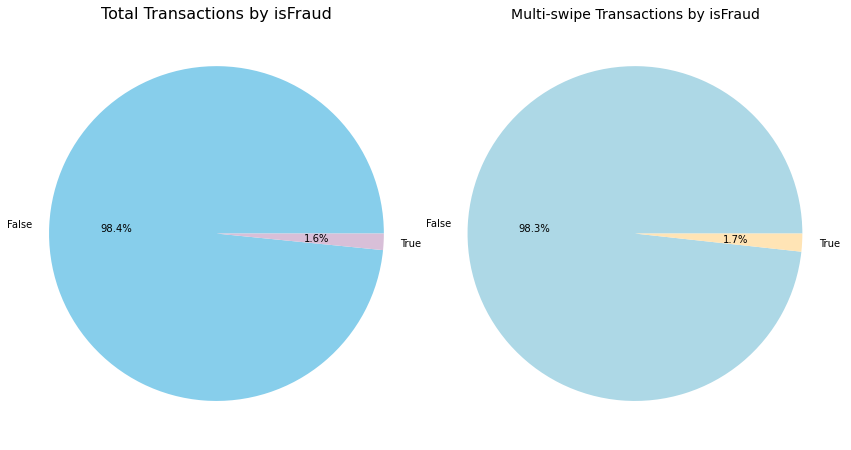

In [29]:
pie_chart(df, df1=multi_swipe_pop, target_col= 'isFraud', 
          colors1 = [ 'skyblue','thistle','pink','navajowhite'], colors2 = ["lightblue", "moccasin"])

__Note:__ For the second question:

- There is not much difference between multi-swipe trancation and all transactions when __comparing the percentage of fraud transaction__
- 1.6% of total transaction is fraud while 1.7% of multi-swipe transaction is fraud. There is not much of a difference.

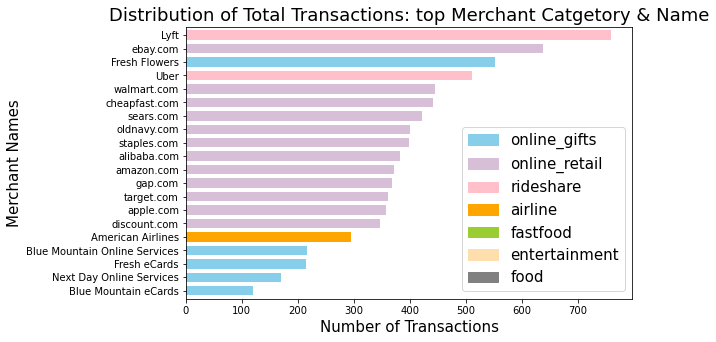

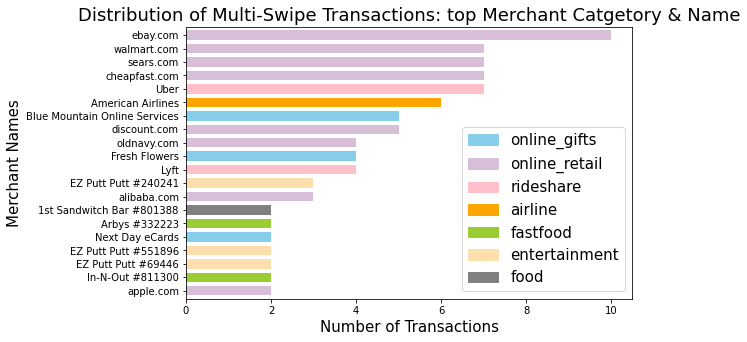

In [30]:
total_merchant_cat_name_fraud = df[df.isFraud== True].groupby(['merchantName','merchantCategoryCode'] ).size().sort_values(ascending=False)
total_merchant_cat_name_fraud_top = pd.DataFrame(total_merchant_cat_name_fraud.head(20)).reset_index()
total_merchant_cat_name_fraud_top = total_merchant_cat_name_fraud_top.rename(columns={0: 'counts'})
total_merchant_cat_name_fraud_top = total_merchant_cat_name_fraud_top.sort_values(by = 'counts')


multi_swipe_merchant_cat_name_fraud = multi_swipe_pop[multi_swipe_pop.isFraud== True].groupby(['merchantName','merchantCategoryCode'] ).size().sort_values(ascending=False)
multi_swipe_merchant_cat_name_fraud_top = pd.DataFrame(multi_swipe_merchant_cat_name_fraud.head(20)).reset_index()
multi_swipe_merchant_cat_name_fraud_top = multi_swipe_merchant_cat_name_fraud_top.rename(columns={0: 'counts'})
multi_swipe_merchant_cat_name_fraud_top = multi_swipe_merchant_cat_name_fraud_top.sort_values(by = 'counts')

bar_plot(df = total_merchant_cat_name_fraud_top , column= 'merchantCategoryCode', x = 'merchantName', y = 'counts',
         title = 'Distribution of Total Transactions: top Merchant Catgetory & Name', 
         xlabel = 'Number of Transactions', ylabel = 'Merchant Names')

bar_plot(df = multi_swipe_merchant_cat_name_fraud_top , column= 'merchantCategoryCode', x = 'merchantName', y = 'counts',
         title = 'Distribution of Multi-Swipe Transactions: top Merchant Catgetory & Name', 
         xlabel = 'Number of Transactions', ylabel = 'Merchant Names')

__Note:__ For the third question:

- There are some difference between multi-swipe trancation and all transactions when __comparing the merchant category/name in fraud transaction__
- For total population, rideshare(Lyft, Uber), online gifts(Fresh Flowers) and online retail(walmart.com, ebay.com) are still the top merchant categories. The only difference is the new category of airline(American Airline), which indicates that American Airline(AA) has more fraud transactions even though the total number of transaction for AA is not large.
- For the multi-swipe population, online retail(ebay.com, walmart.com), rideshare(Uber, Lyft) and some online gifts(Fresh Flowers) are still high in the list, Airline(American Airline) also have relatively high fraud transactions among the total multi-swipe transactions. We have some new categories here: fast food(Arbys, In-N-Out), entertainment(EZ Putt Putt), food(1st Sandwich Bar). The number is not high for these categories, but they are multi-swipe fraud transactions and thus worth paying attention when use our credit cards there.


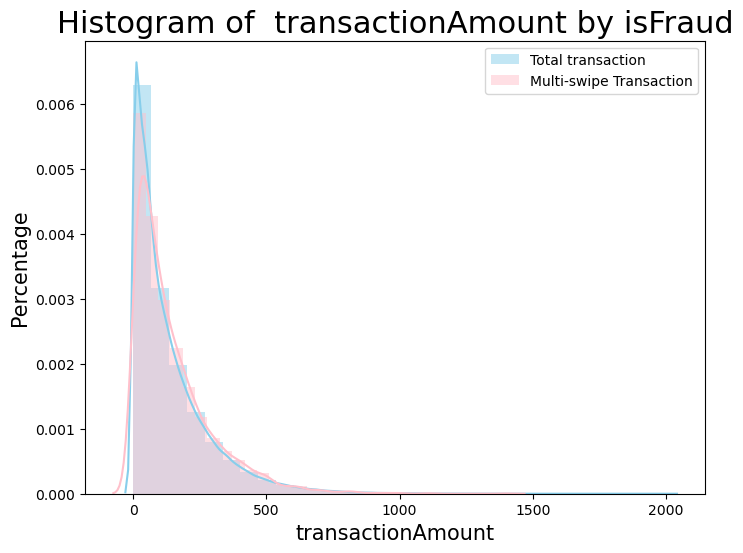

In [31]:
# histogram(df,multi_swipe_pop, 'Total Transaction','Multi-swipe Transaction')
histogram(col='transactionAmount', df1=df, df2=multi_swipe_pop, 
          label1 = 'Total transaction',label2 ='Multi-swipe Transaction', size = (8,6))

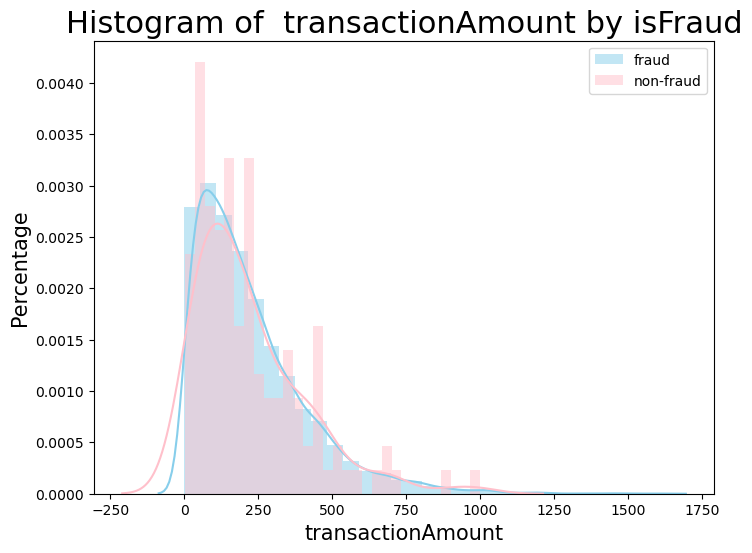

In [32]:
df_fraud = df[df.isFraud == True]
multi_swipe_pop_fraud = multi_swipe_pop[multi_swipe_pop.isFraud == True]
# histogram(df_fraud,multi_swipe_pop_fraud, 'Total Transaction (Fraud)','Multi-swipe Transaction (Fraud)')
histogram(col='transactionAmount', df1=df_fraud, df2=multi_swipe_pop_fraud, 
          label1 = 'fraud',label2 ='non-fraud', size = (8,6))

__Note:__ For the fourth question:

- The difference in transaction amounts between multi-swipe transactions and total transactions is minimal, but there are some difference between fraud multi-swipe trancation and fraud total transactions when __comparing the transaction amounts__.
- When comparing fraud transaction is these 2 populations, the multi-swipe transaction is less regular compared to the total transcation, though it is also right-skewed. The transaction amount for multi-swipe could have a small peak in relatively large amount of transactions (around 1000 dollars and 650 dollars). It indicates that the fraud for multi-swipe is more unpredicable and dangerous as it could be a large amount compare to mostly small amount of fraud in total frauds. 

__Summary:__  
1. There is no large difference between total transaction and multi-swipe transactions   
- regarding merchant categories and name
- percent of fraud transaction
- distribution of transaction amount  

2. But if we only look at fraud transactions, we find something interesting  
- The merchant category Airline(American Airline) has high percentage of transactions in both populations __only for fraud population__. This indicates that American Airline(AA) has more fraud transactions even though the total number of transaction for AA is not large.
- Multi-swipe transactions have more fraud transactions exist in the following merchant categories: fast food(Arbys, In-N-Out), entertainment(EZ Putt Putt), food(1st Sandwich Bar). Despite that there are not a lot of fraud transactions, but they are multi-swipe fraud transactions and thus worth paying attention when use our credit cards there.
- The fraud for multi-swipe is more unpredicable and dangerous as it could be a large amount compare to mostly small amount of fraud in total frauds.

# Question 4: Model

Fraud is a problem for any bank. Fraud can take many forms, whether it is someone stealing a single credit card,
to large batches of stolen credit card numbers being used on the web, or even a mass compromise of credit
card numbers stolen from a merchant via tools like credit card skimming devices.


### 4.1 Data Preprocessing Before Modeling

In [33]:
# import prepared library from util.py
from util1 import target_variable_summary, distribution_plot,remove_missing_values, check_unique_value, distribution,encode_and_bind, high_correlation, impute_missing_value
from util1 import train_test_splits, oversample
from util1 import standardization, DecisionTree,RandomForest, model_pred, plot_confusion_matrix, model_pred
from util1 import plot_confusion_matrix, confusion_matrix, ROC, feature_importance

#### 4.1.1Explore the dataset 

For the total population, Non-Fraud is 98.42%
For the total population, Fraud is 1.58%


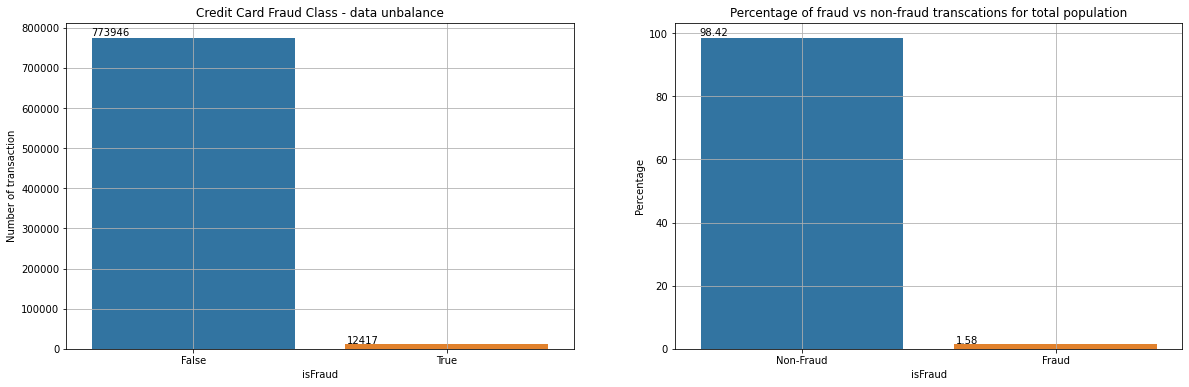

In [34]:
target_variable_summary(df=df, col='isFraud', population= 'total population', labels= ['Non-Fraud', 'Fraud'])

In [35]:
# Generate time related features
df1 = df.copy()
df1['transactionDateTime'] = df1['transactionDateTime'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S'))

df1['transaction_weekday'] = df1['transactionDateTime'].dt.weekday
df1['transaction_hour'] = df1['transactionDateTime'].dt.hour
df1['transaction_day'] = df1['transactionDateTime'].dt.day
df1['transaction_month'] = df1['transactionDateTime'].dt.month

df1['dateOfLastAddressChange'] = pd.to_datetime(df1['dateOfLastAddressChange'])
df1['currentExpDate'] = pd.to_datetime(df1['currentExpDate'])
df1['accountOpenDate'] = pd.to_datetime(df1['accountOpenDate'])
df1['transactionDateTime'] = pd.to_datetime(df1['transactionDateTime'])

# 'dateOfLastAddressChange' transfer to: How many days away from the transaction date?
df1['daysFromLastAddressChange'] = (df1['transactionDateTime'] - df1['dateOfLastAddressChange']).dt.days

# 'currentExpDate' transfer to: How many days away from the transaction date?
df1['daysFromCurrentExpDate'] = (df1['currentExpDate'] - df1['transactionDateTime']).dt.days

# 'accountOpenDate' transfer to: How many days away from the transaction date?
df1['daysFromAccountOpenDate'] = (df1['transactionDateTime'] - df1['accountOpenDate']).dt.days

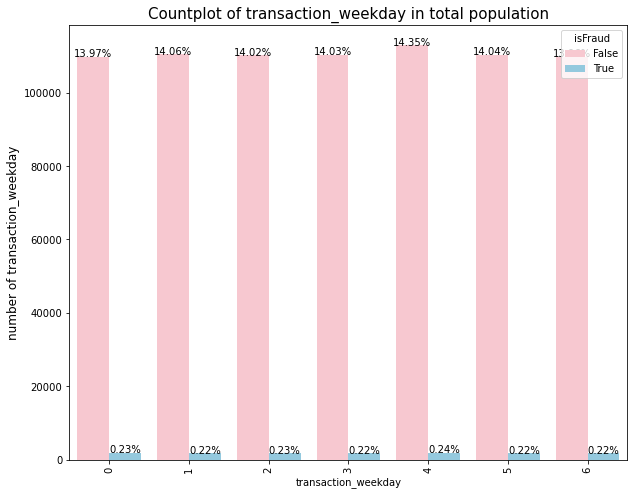

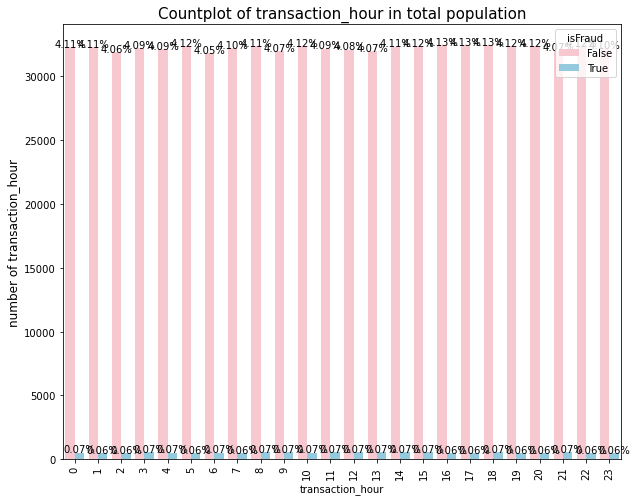

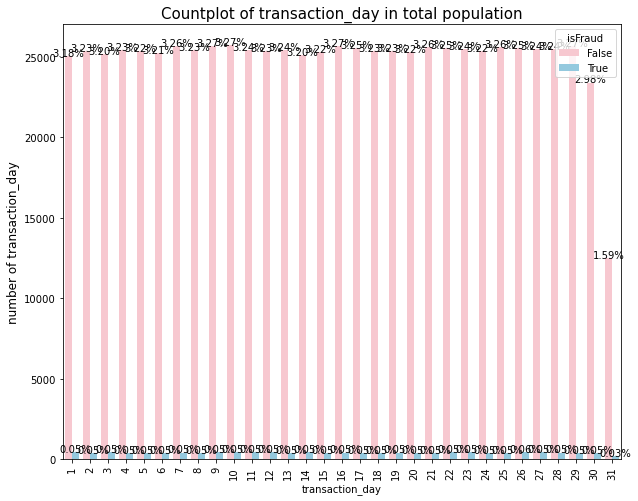

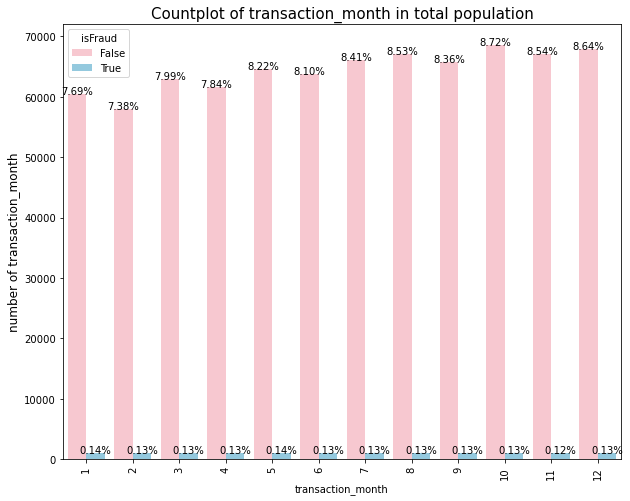

In [36]:
# check the distribution of these time related features
distribution_plot(col='transaction_weekday', data=df1, title='total population',Y='isFraud', overlapping = False, fig_size = (10,8))
distribution_plot(col='transaction_hour', data=df1, title='total population',Y='isFraud', overlapping = False, fig_size = (10,8))
distribution_plot(col='transaction_day', data=df1, title='total population',Y='isFraud', overlapping = False, fig_size = (10,8))
distribution_plot(col='transaction_month', data=df1, title='total population',Y='isFraud', overlapping = False, fig_size = (10,8))

__Note:__ It looks like that there is not much difference between fraud and normal transaction on the transaction happens on which day of the week/ which hour of the day/which day in the month/ which month in a year 

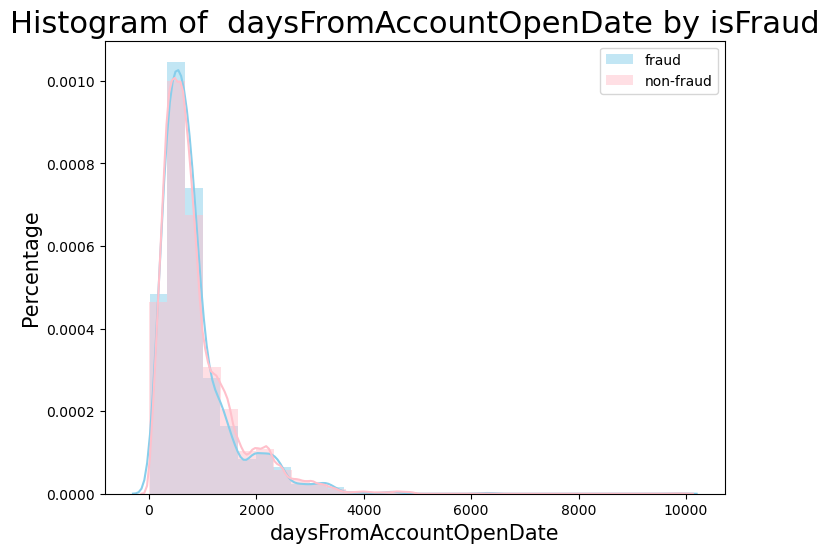

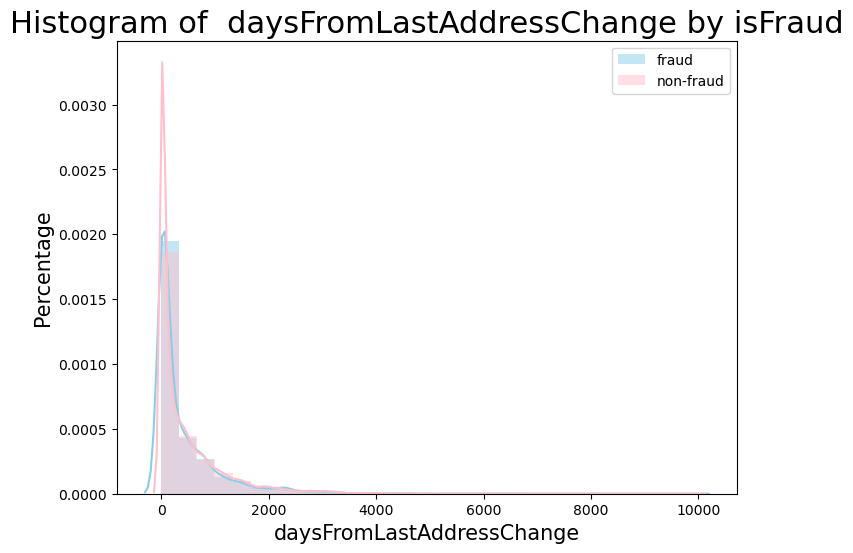

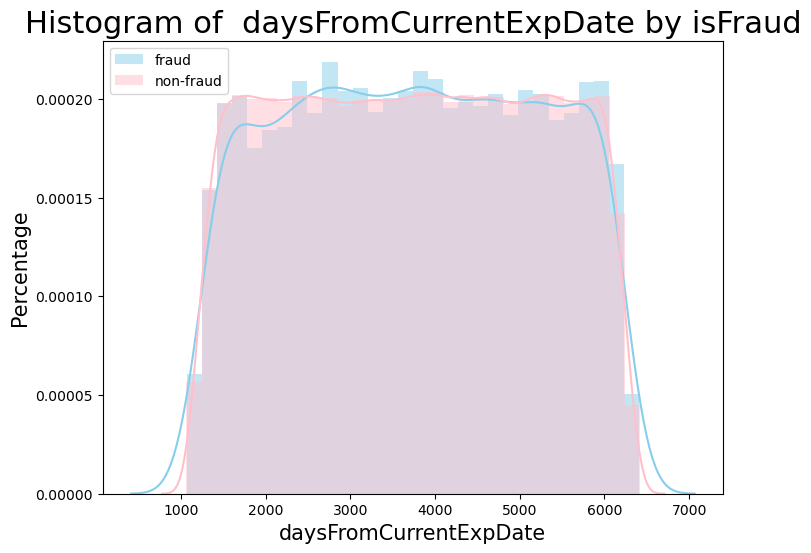

In [37]:
histogram(col='daysFromAccountOpenDate', df1=df1[df1.isFraud == True], df2=df1[df1.isFraud == False], 
          label1 = 'fraud',label2 ='non-fraud', size = (8,6))
histogram(col='daysFromLastAddressChange', df1=df1[df1.isFraud == True], df2=df1[df1.isFraud == False], 
          label1 = 'fraud',label2 ='non-fraud', size = (8,6))
histogram(col='daysFromCurrentExpDate', df1=df1[df1.isFraud == True], df2=df1[df1.isFraud == False], 
          label1 = 'fraud',label2 ='non-fraud', size = (8,6))

__Note:__  
- For daysFromAccountOpenDate, daysFromLastAddressChange, there is not much difference between fraud and normal transaction 
- For daysFromCurrentExpDate, there are more fluctuation for the fraud transactions

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


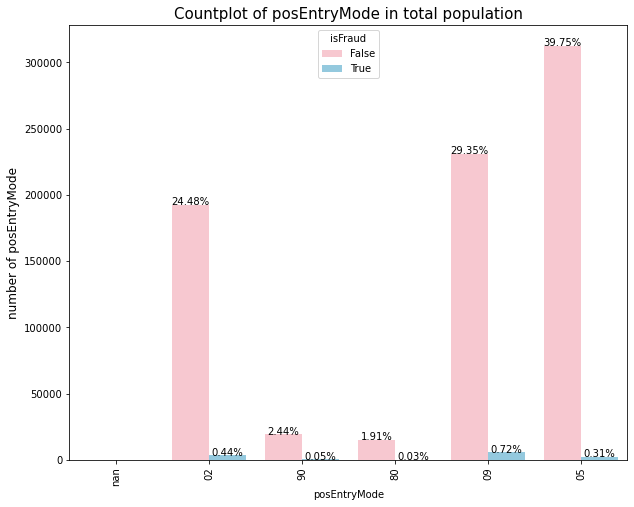

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


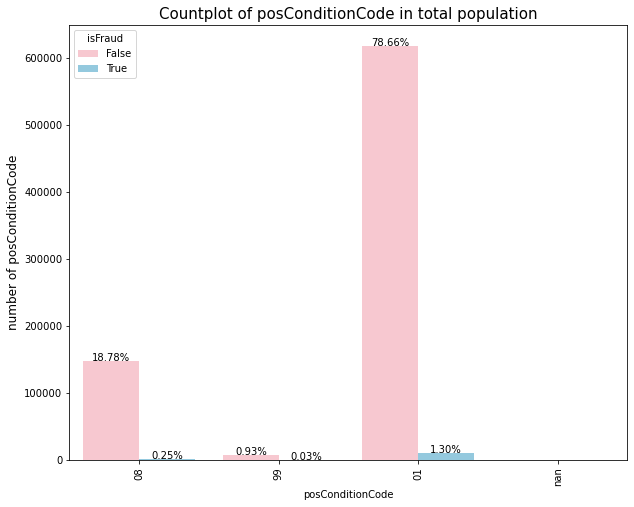

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


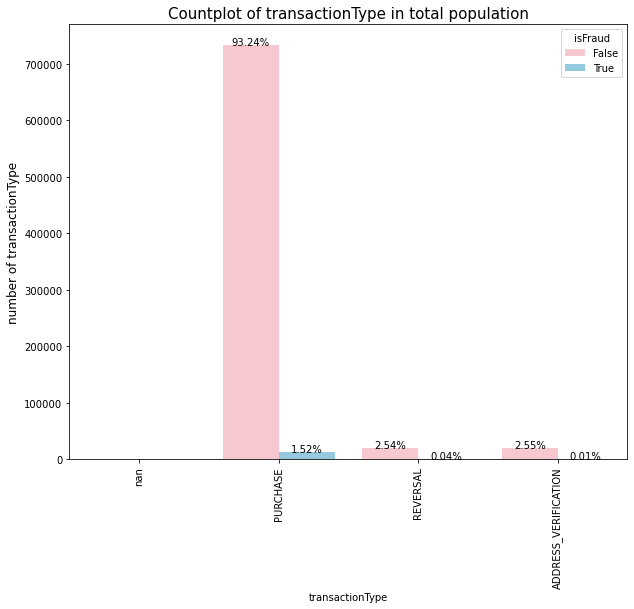

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


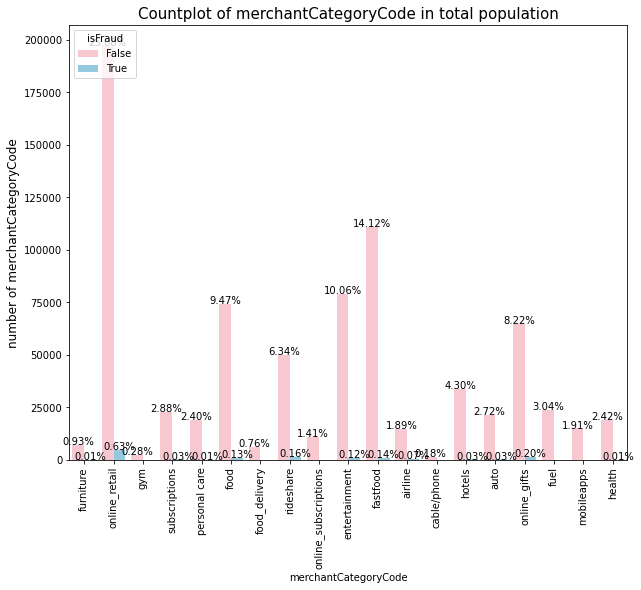

In [38]:
# explore the categorical variables
for col in ['posEntryMode', 'posConditionCode','transactionType','merchantCategoryCode']: 
    distribution_plot(col=col, data=df1, title='total population',Y='isFraud', overlapping = False, fig_size = (10,8))

__Note:__  
These 4 categorical variables do seem to have some variations on fraud vs normal transactions. More investigation could be done here if time allowed.

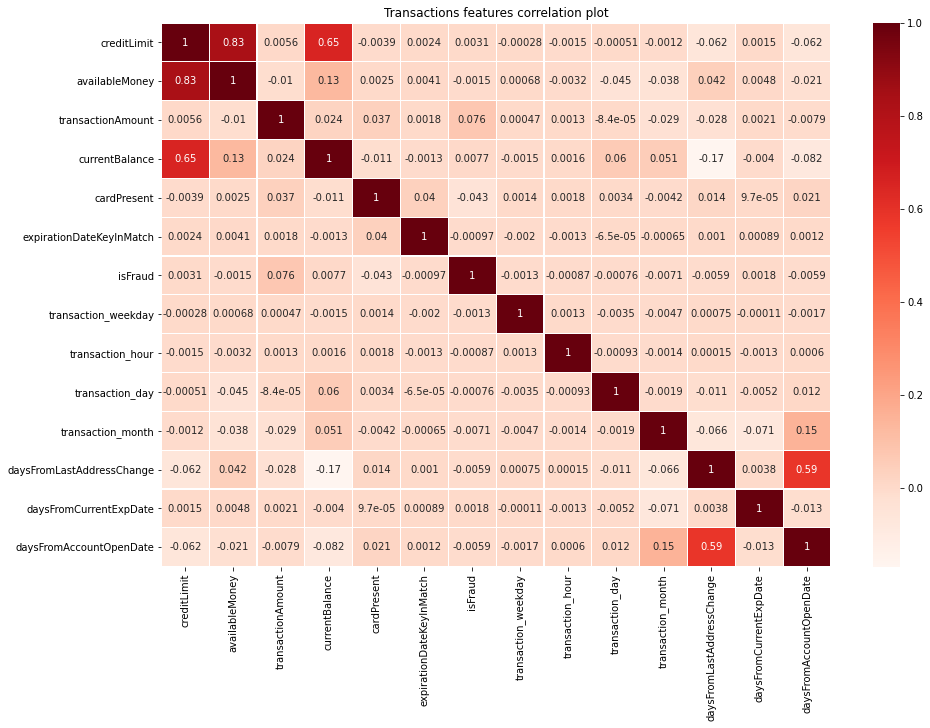

In [39]:
# correlation of variables
plt.figure(figsize = (15,10))
plt.title('Transactions features correlation plot')
temp = df1[df1.columns[df1.isnull().mean() < 0.9]] # only check those columns are mostly not null
corr = temp.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds", annot=True)
plt.show()

__Note:__ 
- It is noted here that most columns are not correlated except for current balance and credit limit, available money and credit limit,  daysFromAccountOpenDate and daysFromLastAddressChange
- In the section of remove high correlated columns, I will set the threshold = 0.5 to remove these highly correlated columns as there are only 3 pairs have relatively high correlations

#### 4.1.2 More Feature Engineering

In [40]:
# add another column to check if the card CVV is correctly entered
df1['enter_correct_CVV'] = df1['cardCVV'] == df1['enteredCVV']
df1.drop(['enteredCVV','cardCVV'], axis=1,inplace = True)

# check if merchant country code is the same as acq country
df1['same_merchant_country'] = df1['acqCountry'] == df1['merchantCountryCode']
df1.drop(['acqCountry','merchantCountryCode'], axis=1,inplace = True)

In [41]:
# use a column to indicate if it is a multi swipe transaction
multi_swipe_pop['isMultiSwipeTranc'] = True
multi_swipe_pop_part = multi_swipe_pop[['accountNumber','customerId','merchantName','transactionAmount','transactionDateTime',
                                        'cardLast4Digits', 'availableMoney','merchantCategoryCode','isMultiSwipeTranc']]
temp = pd.concat([df1, multi_swipe_pop_part], axis=1, join="outer")
temp = temp.loc[:,~temp.columns.duplicated()]
df1 = temp
df1['isMultiSwipeTranc'] = df1['isMultiSwipeTranc'].fillna(False)

#### 4.1.3 Work on categorical variables
As the plot indicate, the categorical variables could make a difference in distinguish fraud and normal transactions. More effort should be spent on this if more time allowed.   
As for now, since merchantName, merchantCategoryCode, posEntryMode are categorical variables with too many distinct categories, it will lead to curse of dimentionality if we conduct one-hot-encoding. We are transform these 2 fields into the __times it appears in the dataset__ .

In [42]:
# transform merchantName
store_times = df1.groupby(['merchantName']).size().reset_index(name = 'store_times')
df2 = pd.merge(store_times, df1, how='outer', on=['merchantName'])

# transform merchantCategoryCode
category_times = df2.groupby(['merchantCategoryCode']).size().reset_index(name = 'category_times')
df3 = pd.merge(category_times, df2, how='outer', on=['merchantCategoryCode'])

# merge to the main dataframe
df3.drop(['merchantName','merchantCategoryCode'], axis = 1, inplace = True)

For 'posEntryMode', 'posConditionCode', 'transactionType' which have less categories, we will use one-hot encoding to transform these categorical variables

In [43]:
for col in ['posEntryMode','posConditionCode', 'transactionType']: 
    df3= encode_and_bind(df3,col)

#### 4.1.4  Data Cleaning 

In [44]:
# remove columns with over 10% of missing values
df4 = remove_missing_values(df3, 90)

# remove columns with only 1 unique value
df4 = check_unique_value(df4)

# check correlations for all the columns
# drop those variables with high correlation coefficient (> 0.5)
df4 = high_correlation(df4, df4.columns, threshold = 0.5)

In [45]:
# delete unnecessary date after feature engineering
df4.drop (['transactionDateTime','currentExpDate', 'accountOpenDate','dateOfLastAddressChange',
           'cardLast4Digits','customerId','accountNumber'], axis = 1, inplace = True)

In [46]:
df4.head()

,store_times,availableMoney,transactionAmount,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transaction_weekday,transaction_hour,transaction_day,transaction_month,daysFromCurrentExpDate,daysFromAccountOpenDate,enter_correct_CVV,same_merchant_country,isMultiSwipeTranc,posEntryMode_02,posEntryMode_05,posEntryMode_09,posEntryMode_80,posEntryMode_90,posConditionCode_01,posConditionCode_08,posConditionCode_99,transactionType_ADDRESS_VERIFICATION,transactionType_PURCHASE,transactionType_REVERSAL
0,3139,4739.87,412.46,260.13,False,False,False,3,3,18,2,2781,706,True,True,False,1,0,0,0,0,1,0,0,0,1,0
1,3139,3561.37,97.37,1438.63,False,False,False,1,17,26,4,1344,774,True,True,False,0,0,1,0,0,1,0,0,0,1,0
2,3139,1429.46,138.03,3570.54,False,False,False,5,2,30,7,5206,869,True,True,True,0,0,0,0,1,1,0,0,0,1,0
3,3139,1316.43,138.03,3683.57,False,False,False,5,4,6,8,5199,876,True,True,False,0,0,0,0,1,1,0,0,0,0,1
4,3139,14711.64,104.96,288.36,False,False,False,1,19,6,12,3646,383,True,True,False,0,1,0,0,0,1,0,0,0,1,0


#### 4.1.5  Save data to csv

In [47]:
# save to csv file
df4.to_csv('df_for_model.csv', index=False)

### 4.2  Modeling

In [48]:
df4 = pd.read_csv('df_for_model.csv')
df4.head()

,store_times,availableMoney,transactionAmount,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transaction_weekday,transaction_hour,transaction_day,transaction_month,daysFromCurrentExpDate,daysFromAccountOpenDate,enter_correct_CVV,same_merchant_country,isMultiSwipeTranc,posEntryMode_02,posEntryMode_05,posEntryMode_09,posEntryMode_80,posEntryMode_90,posConditionCode_01,posConditionCode_08,posConditionCode_99,transactionType_ADDRESS_VERIFICATION,transactionType_PURCHASE,transactionType_REVERSAL
0,3139,4739.87,412.46,260.13,False,False,False,3,3,18,2,2781,706,True,True,False,1,0,0,0,0,1,0,0,0,1,0
1,3139,3561.37,97.37,1438.63,False,False,False,1,17,26,4,1344,774,True,True,False,0,0,1,0,0,1,0,0,0,1,0
2,3139,1429.46,138.03,3570.54,False,False,False,5,2,30,7,5206,869,True,True,True,0,0,0,0,1,1,0,0,0,1,0
3,3139,1316.43,138.03,3683.57,False,False,False,5,4,6,8,5199,876,True,True,False,0,0,0,0,1,1,0,0,0,0,1
4,3139,14711.64,104.96,288.36,False,False,False,1,19,6,12,3646,383,True,True,False,0,1,0,0,0,1,0,0,0,1,0


In [47]:
# separate train and test set (0.7:0.3)
train, test, train_features, train_target, test_features, test_target = train_test_splits(df4,'isFraud',1, 0, 0.7)

# oversample the minority group only on train set using SMOTE
# we'd like to predict on the original test set without oversample
train_oversampled, oversampled_features_df, oversampled_target_df = oversample(train, train_features, train_target,
                                                                               'isFraud', sample_size = 0.1, random_state =0, 
                                                                               k_neighbors=5)
# standardization
oversampled_features_df, test_features = standardization(oversampled_features_df, test_features)

For the Train set, Non-Fraud is 90.91%
For the Train set, Fraud is 9.09%


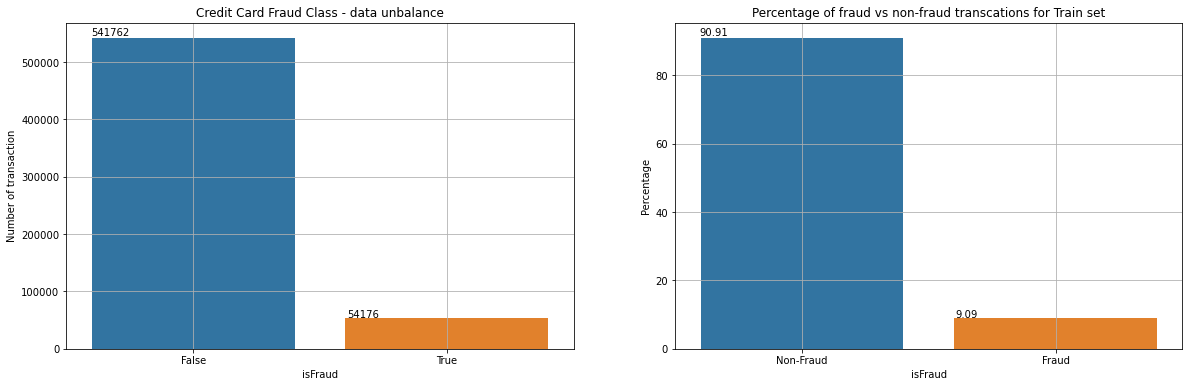

In [48]:
# take a look at train and test set after oversampling
target_variable_summary(df=oversampled_target_df, col='isFraud', population= 'Train set', labels= ['Non-Fraud', 'Fraud'])

For the Test set, Non-Fraud is 98.42%
For the Test set, Fraud is 1.58%


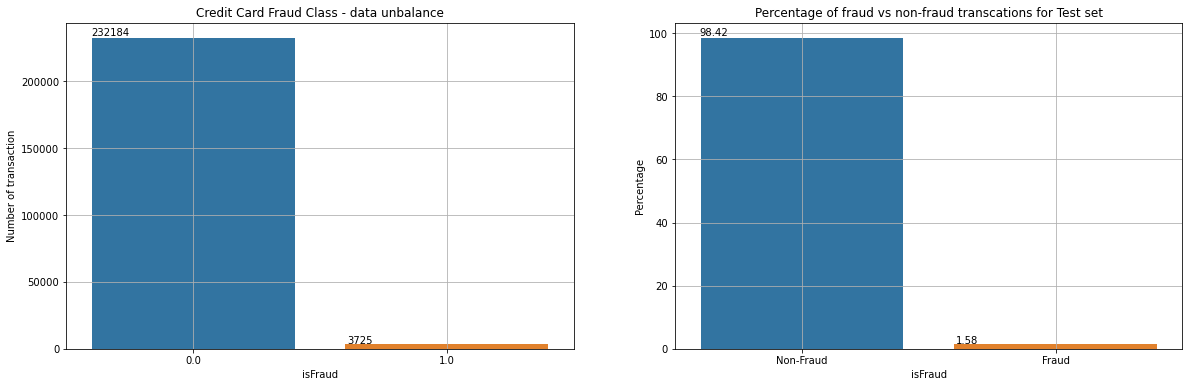

In [49]:
target_variable_summary(df=test, col='isFraud', population= 'Test set', labels= ['Non-Fraud', 'Fraud'])

__Note:__  
- The above 2 pairs of graph shows that we are oversampling the training set (10:1) using SMOTE, but predict on the original test set. The purpose is to show actual predicting power of the model on the real data set
- However, this method will _likely lead to overfitting on the training set_ as the population is oversampled.

__The following sections will solve:__  
- Each of the transactions in the dataset has a field called isFraud . Please build a predictive model to determine whether a given transaction will be fraudulent or not. Use as much of the data as you like (or all of it).  
- Provide an estimate of performance using an appropriate sample, and show your work  
- Please explain your methodology (modeling algorithm/method used and why, what features/data you found useful, what questions you have, and what you would do next with more time)  

### Baseline Model: Logitic Regression



Evaluation Metrics for the Model on Test set is: 

Precision: 0.0668
Recall: 0.0223
F1 score: 0.0334
False Positive Rate: 0.005
False Negative Rate: 0.9777




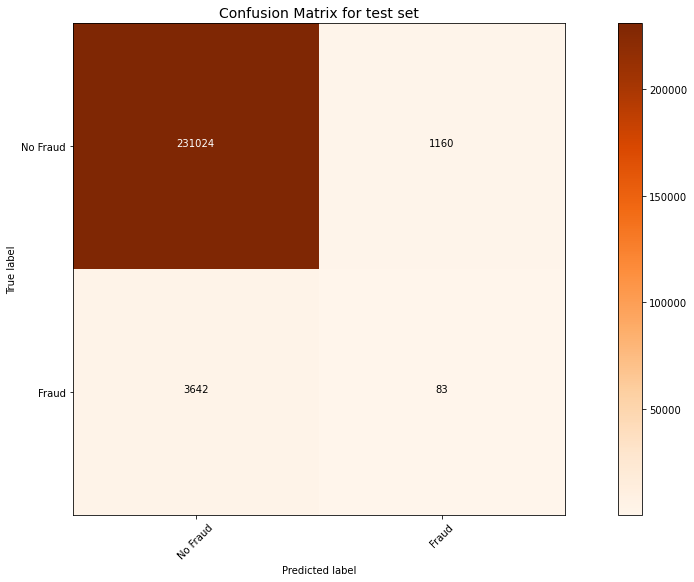

In [50]:
from sklearn.linear_model import LogisticRegression


lg = LogisticRegression(solver='liblinear', penalty = 'l2', random_state=0, max_iter = 200)
lg.fit(oversampled_features_df, oversampled_target_df)

dtrain_predprob, dtest_predprob, dtest_predictions, y_pred_over_threshold = model_pred(lg, oversampled_features_df, oversampled_target_df, 
                                                 test_features, test_target, threshold =0.5,useTrainCV=True, 
                                                 cv_folds=5, early_stopping_rounds=50)

confusion_matrix(oversampled_target_df, test_target, dtrain_predprob, dtest_predprob, dtest_predictions, y_pred_over_threshold)

The ROC curves for train and test set are:
AUC for train set: 0.906071
AUC for test set: 0.703601


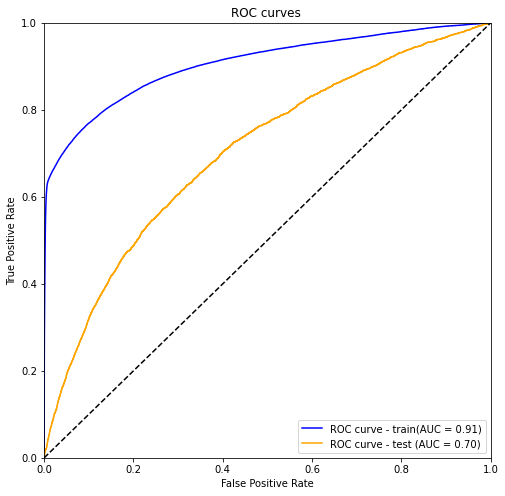

In [51]:
ROC(oversampled_target_df, test_target, dtrain_predprob, dtest_predprob, dtest_predictions, y_pred_over_threshold)

### More Adavanced Models: Random Forest Classifier

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed: 126.1min finished


RandomForestClassifier(class_weight={0: 10, 1: 90}, n_estimators=200)


Evaluation Metrics for the Model on Test set is: 

Precision: 0.1543
Recall: 0.0258
F1 score: 0.0442
False Positive Rate: 0.0023
False Negative Rate: 0.9742




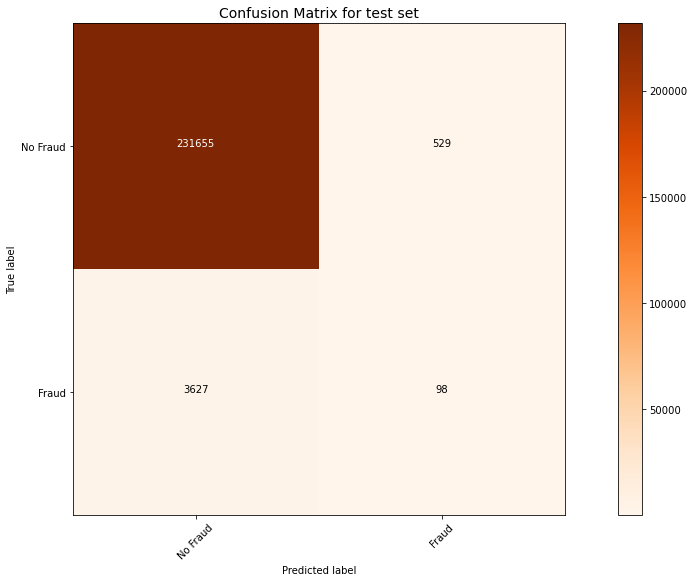

In [53]:
def RandomForest(X_train, Y_train, X_test,Y_test):
    class_weight = dict({1:90, 0:10})

    parameters = {
#                   'n_estimators':(50,100),
                  'criterion':('gini','entropy'),
                  'min_samples_split':(2,4),
                  'min_samples_leaf':(1,3)}

    model = RandomForestClassifier(n_estimators = 200, class_weight=class_weight)
    grid_obj = GridSearchCV(model, param_grid=parameters, cv=5,scoring='roc_auc', verbose=1, n_jobs=4) 
    grid_obj = grid_obj.fit(X_train, Y_train)
    estimator = grid_obj.best_estimator_
    print(estimator)
    return estimator


    
rf = RandomForest(oversampled_features_df, oversampled_target_df, test_features,test_target)
dtrain_predprob2, dtest_predprob2, dtest_predictions2, y_pred_over_threshold2 = model_pred(rf, oversampled_features_df, oversampled_target_df, 
                                                 test_features, test_target, threshold =0.5,useTrainCV=True, 
                                                 cv_folds=5, early_stopping_rounds=50)

confusion_matrix(oversampled_target_df, test_target, dtrain_predprob2, dtest_predprob2, dtest_predictions2, y_pred_over_threshold2)

The ROC curves for train and test set are:
AUC for train set: 1.000000
AUC for test set: 0.750805


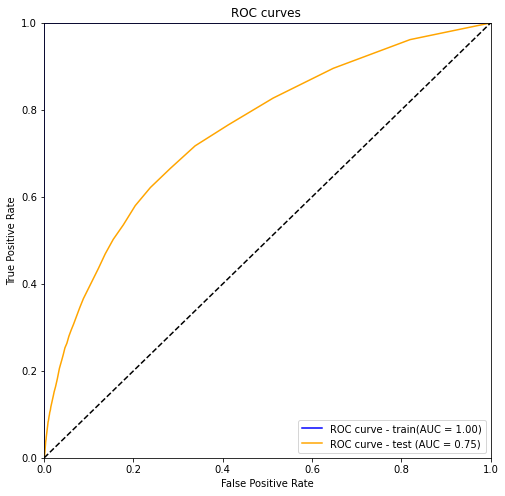

In [54]:
ROC(oversampled_target_df, test_target, dtrain_predprob2, dtest_predprob2, dtest_predictions2, y_pred_over_threshold2)

__Summary Model and Evaluation results__: 

__Model Used:__   
- __Logitic Regression__ is used as baseline model. It models the probabilities for classification problems with two possible outcomes.It is easy to understand, interpretable, and can give pretty good results
- __Random Forest Classifier (RF Classifier)__: similar to a bootstrapping algorithm with Decision tree (CART) model. Random forest tries to build multiple CART models with different samples and different initial variables and average the results to find a stable result. But it usually takes longer to run

__Metrics we care about__:   
- __Precision__: of all transactions that were predicted fraud, how many where actually fraud. A lower precision might lead to customer's complain about too much normal transactions being detected as fraud
- __Recall__: of all fraud transactions, how many did we successfully detect as fraud. A lower recall might lead to miss some true fraud
- __F1 Score__: the harmonic mean of the model's precision and recall
- __ROC_AUC__: is a performance measurement for the classification problems at various threshold settings. It tells how much the model is capable of distinguishing between classes. The higher the AUC, the better the model is at predicting fraud as fraud.


For _test set_, the metrics shows the following result:  

|    | Logisitic Regression (baseline) | RF Classifer |
| --- | --- | --- | 
| AUC | 0.70 | 0.75 | 
| Precision | 0.067 | 0.154 |
| Recall | 0.022 | 0.026 | 
| F1 Score | 0.033 | 0.044 |  

__It is noted from the result that__
- Compare with the baseline model (Logitic Regression), the AUC score for tuned RF Classifier improves from 0.70 to 0.75, precision increases from 0.067 to 0.154, recall increases from 0.022 to 0.026 and F1 score increases from 0.033 to 0.044. 
- The result indicates that the tuned RF Classifier has stronger performance in both detecting the true fraud and minize the false positives, although these results are still not ideal and more investigation should be taken.

__Why using these models:__
- Logistic Regression
    - It is a quick and simple model. It is easy to understand, interpretable, and can give pretty good results.
    - The reason to use it as the baseline model is it takes less time to build (~5 mins) and gives us a relatively accurate overview of how the result might look like. This is crucial to make decisions on the next steps
    - For the negative side, it can only constructs linear boundaries,which would not work well for complex dataset. 
    - Therefore, we use RF Classifier, which is an ensemble of multiple decision trees and could handle complex, non-linear data. 
- RF Classifier
    - It is a tree-based algorithm that leverages the power of multiple decision trees for making decisions.Each node in the decision tree works on a random subset of features to calculate the output. The RF Classifier then combines the output of individual decision trees to generate the final output.
    - It produces more desirable and stable results, but took a long time to tune and train (~120 min)
    - Note: In the RF Classifier, I gave more weights (90%) on the minority group to help us better capture the fraud transaction

### Feature Importance

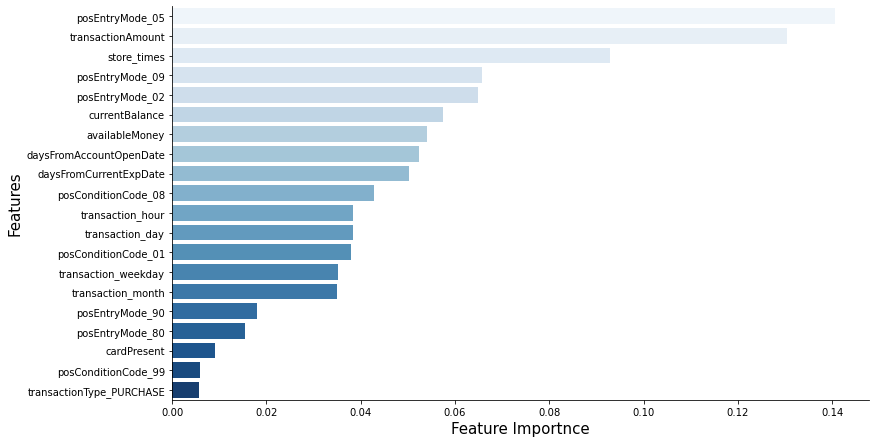

In [58]:
feature_importance(model_name='rf', model = rf, df=oversampled_features_df, top_n = 20)

From the Feature Importance graph above, it is noted that 
- __posEntryMode_05__, __transactionAmount__ and __store_times__ are the top 3 most important indicators to identify fraud. 
- Pos Entry mode is 'is a code that tells the processor how the transaction was captured' and __posEntryMode_05__ indicates that the transaction is through 'Contactless chip card'. That is to say, the transaction amount and whether the transaction is through the contactless chip card will gave us the most information on whether it is a fraud transaction.
- __store_times__ is a build out of the feature 'merchantName', which calculates how many times each merchant name appears. It indicates that some information on the merchant name/category could help us to detect the fraud transactions.

Therefore, Capital One should pay attention to the following aspects of information for a transaction transactions 
- __Different types of Pos entry mode:__ posEntryMode_05, pos_Entry_09, pos_Entry_02
- __Amount:__ transactionAmount, currentBalance, availableMoney
- __merchant information:__ merchant category, merchant name

These information will help us to detect whether this is a fraud transaction.

### Future Work

__More investigation on Feature Engineering__
- Analyze the important features, especially __categorical variables (e.g Pos entry mode, merchant category etc..)__ using visualization and statistical analysis 
- Develop new features based on the analysis and research
- Refit the model. It will potentially increase the model performance as these columns made the biggest contribution to the model

__Solve Overfitting__
-  Part of the reason for overfitting could be we are only oversampling the training set but not the test set. More research should be done to solve this issue--make sure the model performance works on the real dataset while keep it from overfitting
- Try some other techniques such as PCA, Lasso Regression to reduce dimensionality while improve the quality of features
- Increase n_estimator in Random Forest Classifier, as the bigger this number, the less likely the forest is to overfit
- Limit the max_depth to be in (5,15) in Random Forest Classifier, as the deeper the tree is, the more likely it is to overfit
- More tuning on other hyperparameters should be investigated.  

__Model Selection__
- Experiment on other models if time is allowed: 
    - Boosting model: it builds trees sequentially correcting the errors from the the prior tree, especially Catboost/LightGBM which could deal with categorical variables without prepocessing.
    - SVM: it performs well with high-dimensional data, especially with different kernel tricks
    - Neural Network: it is expected to have good performance when the data set is complex

__Model Insights__
- More insights from the model/analysis could be extracted. It will help Capital One to make alerts to the customers and thus reduce the cost. It will be valuable to answer the following questions:
    - A transaction happens during what time and how much amount is more likely to be a fraud tranction?
    - Is there one merchant name/category more likely to have fraud transaction? Why?
    - What would be a safer way to use the card based on the posEntryMode?
    - ...